Network-In-Network
=============

[https://arxiv.org/abs/1312.4400](https://arxiv.org/abs/1312.4400)

With batch_norm folded into convolutional layers for speed.

## Network info

Trained in: [fb.resnet.torch](https://github.com/facebook/fb.resnet.torch)
    
Test top-1/top5 error: **32.96, 12.29**

In [1]:
import re
import hickle as hkl
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from visualize import make_dot

In [100]:
params = hkl.load('nin-export.hkl')

# convert numpy arrays to torch Variables
for k,v in sorted(params.iteritems()):
    print k, v.shape
    params[k] = Variable(torch.from_numpy(v))
    
print '\nTotal parameters:', sum([v.numel() for v in params.itervalues()])

conv0.bias (96,)
conv0.weight (96, 3, 11, 11)
conv1.bias (96,)
conv1.weight (96, 96, 1, 1)
conv10.bias (1024,)
conv10.weight (1024, 1024, 1, 1)
conv11.bias (1024,)
conv11.weight (1024, 1024, 1, 1)
conv2.bias (96,)
conv2.weight (96, 96, 1, 1)
conv3.bias (256,)
conv3.weight (256, 96, 5, 5)
conv4.bias (256,)
conv4.weight (256, 256, 1, 1)
conv5.bias (256,)
conv5.weight (256, 256, 1, 1)
conv6.bias (384,)
conv6.weight (384, 256, 3, 3)
conv7.bias (384,)
conv7.weight (384, 384, 1, 1)
conv8.bias (384,)
conv8.weight (384, 384, 1, 1)
conv9.bias (1024,)
conv9.weight (1024, 384, 3, 3)
fc.bias (1000,)
fc.weight (1000, 1024)

Total parameters: 8644776


## PyTorch model definition

In [101]:
def f(inputs, params):
    def conv2d(x, params, name, stride=1, padding=0):
        return F.conv2d(x,
                        params['%s.weight'%name],
                        params['%s.bias'%name], stride, padding)

    def block(x, names, stride, padding):
        x = F.relu(conv2d(x, params, names[0], stride, padding))
        x = F.relu(conv2d(x, params, names[1]))
        x = F.relu(conv2d(x, params, names[2]))
        return x

    o = block(inputs, ['conv0', 'conv1', 'conv2'], 4, 5)
    o = F.max_pool2d(o, 2)
    o = block(o, ['conv3', 'conv4', 'conv5'], 1, 2)
    o = F.max_pool2d(o, 2)
    o = block(o, ['conv6', 'conv7', 'conv8'], 1, 1)
    o = F.max_pool2d(o, 2)
    o = block(o, ['conv9', 'conv10', 'conv11'], 1, 1)
    o = F.avg_pool2d(o, 7)
    o = o.view(o.size(0), -1)
    o = F.linear(o, params['fc.weight'], params['fc.bias'])
    return o

do simple fprop, output shape should be 1x1000

In [102]:
inputs = torch.randn(1,3,224,224)
y = f(Variable(inputs), params)
print y

Variable containing:
-0.8835  0.7640 -1.5599  ...   0.0415  1.7123  2.0368
[torch.FloatTensor of size 1x1000]



# Visualization

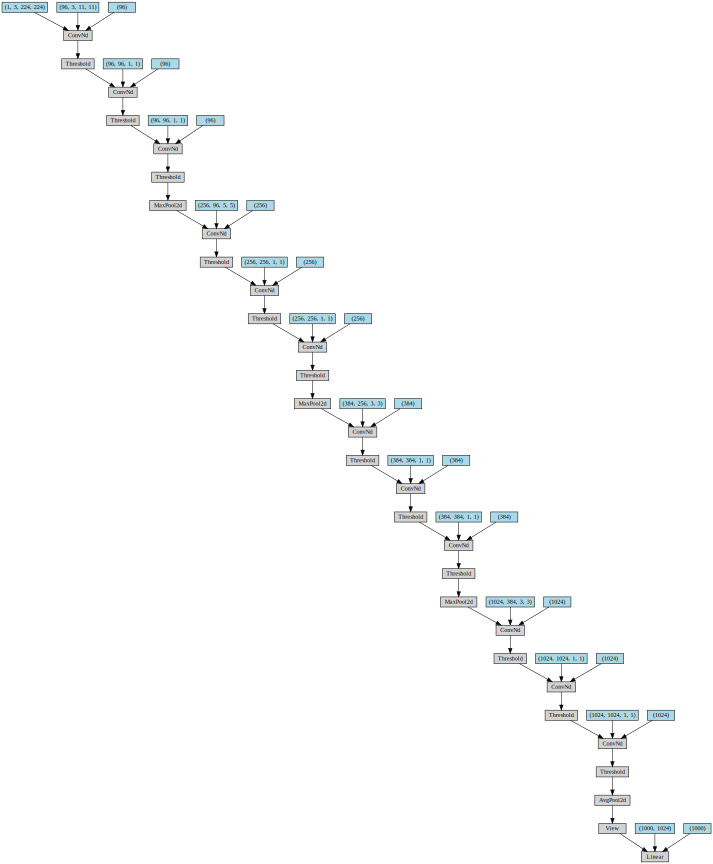

In [30]:
make_dot(y)

## Tensorflow model definition

In [119]:
import tensorflow as tf
import numpy as np

def g(inputs, params):
    def tr(v):
        if v.ndim == 4:
            return v.transpose(2,3,1,0)
        elif v.ndim == 2:
            return v.transpose()
        return v
    params = {k: tf.constant(tr(v)) for k, v in params.iteritems()}
    
    def conv2d(x, params, name, stride=1, padding=0):
        x = tf.pad(x, [[0,0],[padding,padding],[padding,padding],[0,0]])
        z = tf.nn.conv2d(x, params['%s.weight'%name], [1,stride,stride,1],
                         padding='VALID')
        return tf.nn.bias_add(z, params['%s.bias'%name])
    
    def pool(f, x, stride):
        return f(o,
                 ksize=[1,stride,stride,1],
                 strides=[1,stride,stride,1],
                 padding='SAME')
    
    def block(x, names, stride=1, padding=0):
        x = tf.nn.relu(conv2d(x, params, names[0], stride, padding))
        x = tf.nn.relu(conv2d(x, params, names[1]))
        x = tf.nn.relu(conv2d(x, params, names[2]))
        return x
    
    o = block(inputs, ['conv0', 'conv1', 'conv2'], 4, 5)
    o = pool(tf.nn.max_pool, o, 2)
    o = block(o, ['conv3', 'conv4', 'conv5'], 1, 2)
    o = pool(tf.nn.max_pool, o, 2)
    o = block(o, ['conv6', 'conv7', 'conv8'], 1, 1)
    o = pool(tf.nn.max_pool, o, 2)
    o = block(o, ['conv9', 'conv10', 'conv11'], 1, 1)
    o = pool(tf.nn.avg_pool, o, 7)
    o = tf.reshape(o, [-1,1024])
    o = tf.matmul(o, params['fc.weight']) + params['fc.bias']
    return o

params = hkl.load('nin-export.hkl')
inputs_tf = tf.placeholder(tf.float32, shape=[None,224,224,3])

out = g(inputs_tf, params)

sess = tf.Session()
y_tf = sess.run(out, feed_dict={inputs_tf: inputs.permute(0,2,3,1).numpy()})

# check that difference between PyTorch and Tensorflow is small
assert np.abs(y_tf - y.data.numpy()).max() < 1e-5